<a href="https://colab.research.google.com/github/element-fi/elf-simulations/blob/dp_mart_agents/examples/notebooks/fred_louie_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hyperdrive [NAME] simulation
We use the following setup:
- TBD
* variable rate:
    * step function
    * rate changes every 3 months
    * 

For details on the simulation framework, please see our <a href="https://elfpy.element.fi/">simulation documentation</a>

### Install repo requirements & import packages

In [491]:
# test: skip-cell
try: # install dependencies only if running on google colab
    import google.colab # check if running in colab
    !pip install -r https://raw.githubusercontent.com/element-fi/elf-simulations/main/requirements-3.8.txt 
    !pip install git+https://github.com/element-fi/elf-simulations.git
except:
    print("running locally & trusting that you have the dependencies installed")

running locally & trusting that you have the dependencies installed


In [492]:
from __future__ import annotations

import numpy as np
from numpy.random._generator import Generator
import matplotlib.ticker as ticker

from elfpy import WEI
from elfpy.agents.agent import Agent
from elfpy.utils import sim_utils
from elfpy.simulators import Config

import elfpy.markets.hyperdrive.hyperdrive_market as hyperdrive_market
import elfpy.markets.hyperdrive.hyperdrive_actions as hyperdrive_actions
import elfpy.utils.outputs as output_utils
import elfpy.utils.post_processing as post_processing
import elfpy.types as types

### Setup experiment parameters

In [513]:
len(final_array)

42

In [533]:
config = Config()

# General config parameters
config.title = "Hyperdrive smart agent demo"
config.pricing_model_name = "Hyperdrive" # can be yieldspace or hyperdrive

config.num_trading_days = 20##20#1095 # Number of simulated trading days
config.num_blocks_per_day = 5##5#7200 # Blocks in a given day (7200 means ~12 sec per block)
config.num_position_days = 10#5##10#90 # How long a token reaches maturity

config.curve_fee_multiple = 0.05 # fee multiple applied to the price slippage (1-p) collected on trades
config.flat_fee_multiple = 0.05 # fee collected on the spread of the flat portion

config.target_fixed_apr = 0.01 # target fixed APR of the initial market after the LP
config.target_liquidity = 500_000_000 # target total liquidity of the initial market, before any trades

config.log_level = output_utils.text_to_log_level("INFO") # Logging level, should be in ["DEBUG", "INFO", "WARNING"]
config.log_filename = "frida_n_louie" # Output filename for logging

config.shuffle_users = True

# Notebook specific parameters
num_fridas = 15 #15
num_louies = 20 * num_fridas
num_agents = num_fridas + num_louies # int specifying how many agents you want to simulate
trade_chance = 0.1 # 1 / (config.num_trading_days * num_agents) # on a given block, an agent will trade with probability `trade_chance`

louie_budget_mean = 375_000
louie_budget_std = 25_000

louie_budget_max = 1_00_000
louie_budget_min = 1_000

frida_budget_mean = 1_000
frida_budget_std = 500

frida_budget_max = 1_00_000
frida_budget_min = 1_000

frida_risk_min = 0.0
frida_risk_max = 0.06
frida_risk_mean = 0.02
frida_risk_std = 0.01

# Define the vault apr
vault_apr = np.array([0.01]*config.num_trading_days)
#vault_apr[config.num_trading_days//2:] = 0.05
#vault_apr[config.num_trading_days//3:config.num_trading_days * 2//3] = 0.08
#vault_apr[config.num_trading_days * 2//3:] = 0.025
#vault_apr[config.num_trading_days//4:config.num_trading_days * 2//4] = 0.03
vault_apr = np.array([0.1, 0.1, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.3, 0.4, 0.4, 0.3, 0.3, 0.2, 0.2, 0.2]) * 0.1
config.variable_apr = vault_apr.tolist()
config.freeze()

fig_size = (10, 10)

In [534]:
print(vault_apr)

[0.01 0.01 0.02 0.02 0.02 0.03 0.03 0.03 0.03 0.03 0.02 0.02 0.03 0.04
 0.04 0.03 0.03 0.02 0.02 0.02]


### Setup agents

In [535]:
class FixedFrida(Agent):
    """
    Agent that paints & opens fixed rate borrow positions
    """

    def __init__(self, rng: Generator, trade_chance: float, risk_threshold: float, wallet_address: int, budget: int = 10_000) -> None:
        """Add custom stuff then call basic policy init"""
        self.trade_chance = trade_chance
        self.risk_threshold = risk_threshold
        self.rng = rng
        super().__init__(wallet_address, budget)

    def action(self, market: hyperdrive_market.Market) -> list[types.Trade]:
        """Implement a Fixed Frida user strategy

        I'm an actor with a high risk threshold
        I'm willing to open up a fixed-rate borrow (aka a short) if the fixed rate is ~2% higher than the variable rate
            approx means gauss mean=0.02; std=0.005, clipped at 0, 5
        I will never close my short until the simulation stops
            UNLESS my short reaches the token duration mark (e.g. 6mo)
            realistically, people might leave them hanging
        I have total budget of 2k -> 250k (gauss mean=75k; std=50k, i.e. 68% values are within 75k +/- 50k)
        I only open one short at a time

        Parameters
        ----------
        market : Market
            the trading market

        Returns
        -------
        action_list : list[MarketAction]
        """
        # Any trading at all is based on a weighted coin flip -- they have a trade_chance% chance of executing a trade
        gonna_trade = self.rng.choice([True, False], p=[self.trade_chance, 1-self.trade_chance])
        if not gonna_trade:
            return []
        
        action_list = []
        for short_time in self.wallet.shorts: # loop over shorts
            if (market.block_time.time - short_time) >= market.annualized_position_duration: # if any short is mature
                trade_amount = self.wallet.shorts[short_time].balance # close the whole thing
                action_list += [
                    types.Trade(
                        market=types.MarketType.HYPERDRIVE,
                        trade=hyperdrive_actions.MarketAction(
                            action_type=hyperdrive_actions.MarketActionType.CLOSE_SHORT,
                            trade_amount=trade_amount,
                            wallet=self.wallet,
                            mint_time=short_time,
                        ),
                    )
                ]

        short_balances = [short.balance for short in self.wallet.shorts.values()]
        has_opened_short = bool(any(short_balance > 0 for short_balance in short_balances))
        # only open a short if the fixed rate is 0.02 or more lower than variable rate
        if (market.fixed_apr - market.market_state.variable_apr) < self.risk_threshold and not has_opened_short: 
            trade_amount = self.get_max_short(market) # maximum amount the agent can short given the market and the agent's wallet
            if trade_amount > WEI:
                action_list += [
                    types.Trade(
                        market=types.MarketType.HYPERDRIVE,
                        trade=hyperdrive_actions.MarketAction(
                            action_type=hyperdrive_actions.MarketActionType.OPEN_SHORT,
                            trade_amount=trade_amount,
                            wallet=self.wallet,
                            mint_time=market.block_time.time,
                        )
                    )
                ]

        return action_list

In [536]:
class LongLouie(Agent):
    """
    Long-nosed agent that opens longs
    """

    def __init__(self, rng: Generator, trade_chance: float, risk_threshold: float, wallet_address: int, budget: int = 10_000) -> None:
        """Add custom stuff then call basic policy init"""
        self.trade_chance = trade_chance
        self.risk_threshold = risk_threshold
        self.rng = rng
        super().__init__(wallet_address, budget)

    def action(self, market: hyperdrive_market.Market) -> list[types.Trade]:
        """Implement a Long Louie user strategy

        I'm not willing to open a long if it will cause the fixed-rate apr to go below the variable rate
            I simulate the outcome of my trade, and only execute on this condition
        I only close if the position has matured
        I have total budget of 2k -> 250k (gauss mean=75k; std=50k, i.e. 68% values are within 75k +/- 50k)
        I only open one long at a time

        Parameters
        ----------
        market : Market
            the trading market

        Returns
        -------
        action_list : list[MarketAction]
        """
        # Any trading at all is based on a weighted coin flip -- they have a trade_chance% chance of executing a trade
        gonna_trade = self.rng.choice([True, False], p=[self.trade_chance, 1-self.trade_chance])
        if not gonna_trade:
            return []
        
        action_list = []
        for long_time in self.wallet.longs: # loop over longs
            if (market.block_time.time - long_time) >= market.annualized_position_duration: # if any long is mature
                trade_amount = self.wallet.longs[long_time].balance # close the whole thing
                action_list += [
                    types.Trade(
                        market=types.MarketType.HYPERDRIVE,
                        trade=hyperdrive_actions.MarketAction(
                            action_type=hyperdrive_actions.MarketActionType.CLOSE_LONG,
                            trade_amount=trade_amount,
                            wallet=self.wallet,
                            mint_time=long_time,
                        )
                    )
                ]

        long_balances = [long.balance for long in self.wallet.longs.values()]
        has_opened_long = bool(any(long_balance > 0 for long_balance in long_balances))
        # only open a long if the fixed rate is higher than variable rate
        if (market.fixed_apr - market.market_state.variable_apr) > self.risk_threshold and not has_opened_long: # risk_threshold = 0
            total_bonds_to_match_variable_apr = market.pricing_model.calc_bond_reserves(
                target_apr=market.market_state.variable_apr, # fixed rate targets the variable rate
                time_remaining=market.position_duration,
                market_state=market.market_state
            )
            # get the delta bond amount & convert units
            new_bonds_to_match_variable_apr = (market.market_state.bond_reserves - total_bonds_to_match_variable_apr) * market.spot_price
            # divide by 2 to adjust for changes in share reserves when the trade is executed
            adjusted_bonds = new_bonds_to_match_variable_apr / 2
            # get the maximum amount the agent can long given the market and the agent's wallet
            max_trade_amount = self.get_max_long(market) 
            trade_amount = np.minimum(max_trade_amount, adjusted_bonds) # don't want to trade more than the agent has or more than the market can handle
            if trade_amount > WEI:
                action_list += [
                    types.Trade(
                        market=types.MarketType.HYPERDRIVE,
                        trade=hyperdrive_actions.MarketAction(
                            action_type=hyperdrive_actions.MarketActionType.OPEN_LONG,
                            trade_amount=trade_amount,
                            wallet=self.wallet,
                            mint_time=market.block_time.time,
                        )
                    )
                ]
        return action_list

In [537]:
class LPAgent(Agent):
    """Adds a large LP"""
    def action(self, market: hyperdrive_market.Market):
        """implement user strategy"""
        if self.wallet.lp_tokens > 0: # has already opened the lp
            action_list = []
        else:
            action_list = [
                types.Trade(
                    market=types.MarketType.HYPERDRIVE,
                    trade=hyperdrive_actions.MarketAction(
                        action_type=hyperdrive_actions.MarketActionType.ADD_LIQUIDITY,
                        trade_amount=self.budget,
                        wallet=self.wallet,
                    ),
                )
            ]
        return action_list

In [538]:

def get_example_agents(rng: Generator, num_fridas: int, num_louies: int, existing_agents: int = 0) -> list[Agent]:
    """Instantiate a set of custom agents"""
    agents = []
    for address in range(existing_agents, existing_agents + num_fridas):
        risk_threshold = np.maximum(frida_risk_min, np.minimum(frida_risk_max, rng.normal(loc=frida_risk_mean, scale=frida_risk_std)))
        budget = np.maximum(frida_budget_min, np.minimum(250_000, rng.normal(loc=frida_budget_mean, scale=frida_budget_std)))
        agent = FixedFrida(
            rng=rng,
            trade_chance=trade_chance,
            risk_threshold=risk_threshold,
            wallet_address=address,
            budget=budget,
        )
        agent.log_status_report()
        agents += [agent]
    existing_agents += len(agents)
    for address in range(existing_agents, existing_agents + num_louies):
        risk_threshold = 0.0
        budget = np.maximum(louie_budget_min, np.minimum(250_000, rng.normal(loc=louie_budget_mean, scale=louie_budget_std)))
        agent = LongLouie(
            rng=rng,
            trade_chance=trade_chance,
            risk_threshold=risk_threshold,
            wallet_address=address,
            budget=budget,
        )
        agent.log_status_report()
        agents += [agent]
    return agents

### Setup simulation objects

In [539]:
# define root logging parameters
output_utils.setup_logging(log_filename=config.log_filename, log_level=config.log_level)

# get an instantiated simulator object
simulator = sim_utils.get_simulator(config)

### Run the simulation

In [540]:
# add the random agents
trading_agents = get_example_agents(
    rng=simulator.rng,
    num_fridas=num_fridas,
    num_louies=num_louies,
    existing_agents=len(simulator.agents)
)
simulator.add_agents(trading_agents)
print(f"Simulator has {len(simulator.agents)} agents")

# run the simulation
simulator.run_simulation()

Simulator has 316 agents


In [541]:
# convert simulation state to a pandas dataframe
trades = post_processing.compute_derived_variables(simulator)

### Plot simulation results


### variable & fixed apr

In [542]:
trades

,index,model_name,run_number,day,block_number,daily_block_number,current_time,trade_number,time_step_size,position_duration,...,agent_311_pnl,agent_311_pnl_no_mock,agent_312_pnl,agent_312_pnl_no_mock,agent_313_pnl,agent_313_pnl_no_mock,agent_314_pnl,agent_314_pnl_no_mock,agent_315_pnl,agent_315_pnl_no_mock
0,0,Hyperdrive,0,0,0,0,0.000000,0,0.000548,"StretchedTime(days=10, time_stretch=110.934385...",...,250000.0,250000.0,250000.00000,250000.00000,250000.000000,250000.000000,250000.000000,250000.000000,250000.0,250000.0
1,1,Hyperdrive,0,0,1,1,0.000548,1,0.000548,"StretchedTime(days=10, time_stretch=110.934385...",...,250000.0,250000.0,250000.00000,250000.00000,250000.000000,250000.000000,250000.000000,250000.000000,250000.0,250000.0
2,2,Hyperdrive,0,0,1,1,0.000548,2,0.000548,"StretchedTime(days=10, time_stretch=110.934385...",...,250000.0,250000.0,250000.00000,250000.00000,250000.000000,250000.000000,250000.000000,250000.000000,250000.0,250000.0
3,3,Hyperdrive,0,0,1,1,0.000548,3,0.000548,"StretchedTime(days=10, time_stretch=110.934385...",...,250000.0,250000.0,250000.00000,250000.00000,250000.000000,250000.000000,250000.000000,250000.000000,250000.0,250000.0
4,4,Hyperdrive,0,0,1,1,0.000548,4,0.000548,"StretchedTime(days=10, time_stretch=110.934385...",...,250000.0,250000.0,250000.00000,250000.00000,250000.000000,250000.000000,250000.000000,250000.000000,250000.0,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,442,Hyperdrive,0,19,99,4,0.054247,442,0.000548,"StretchedTime(days=10, time_stretch=110.934385...",...,250000.0,250000.0,237682.58891,237682.58891,237643.414217,237643.414217,237680.631543,237680.631543,250000.0,250000.0
443,443,Hyperdrive,0,19,99,4,0.054247,443,0.000548,"StretchedTime(days=10, time_stretch=110.934385...",...,250000.0,250000.0,237682.58891,237682.58891,237643.414217,237643.414217,237680.631543,237680.631543,250000.0,250000.0
444,444,Hyperdrive,0,19,99,4,0.054247,444,0.000548,"StretchedTime(days=10, time_stretch=110.934385...",...,250000.0,250000.0,237682.58891,237682.58891,237643.414217,237643.414217,237680.631543,237680.631543,250000.0,250000.0
445,445,Hyperdrive,0,19,99,4,0.054247,445,0.000548,"StretchedTime(days=10, time_stretch=110.934385...",...,250000.0,250000.0,237682.58891,237682.58891,237643.414217,237643.414217,237680.631543,237680.631543,250000.0,250000.0


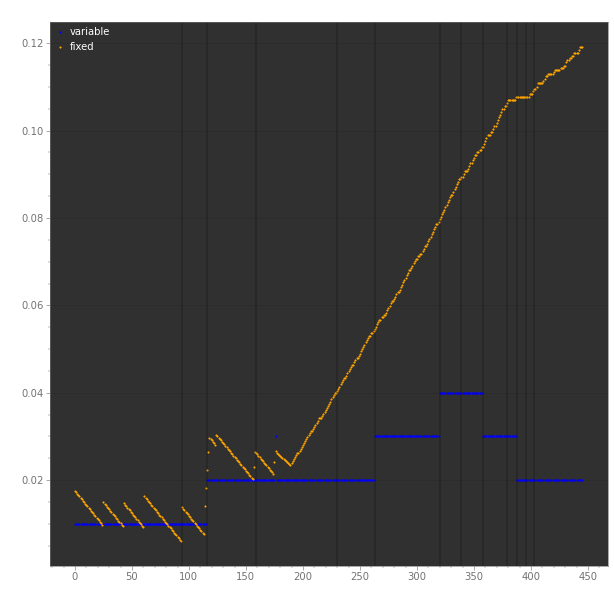

In [543]:
# BY TRADE NUMBER
fig, axes, _ = output_utils.get_gridspec_subplots()
ax = axes[0]
start_index = 0
end_index = -1
spot_size = 2.
ax.scatter(trades.iloc[start_index:end_index]["trade_number"], trades.iloc[start_index:end_index]["variable_apr"], label="variable", c="blue", s=spot_size)
ax.scatter(trades.iloc[start_index:end_index]["trade_number"], trades.iloc[start_index:end_index]["fixed_apr"], label="fixed", c="orange", s=spot_size)

ax.set_title("Interest rates over time")
ax.set_xlabel("trade number")
ax.set_ylabel("APR")
ax.legend()

ax.grid(axis="x", which="both", color="black", alpha=0)
day_data=np.nonzero(np.array(trades.iloc[start_index:end_index]["day"].diff())==1)[0] # each black vertical line represents transition between days
for x in day_data:
    ax.axvline(x, c="black", alpha=0.2)

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
fig.set_size_inches(fig_size)

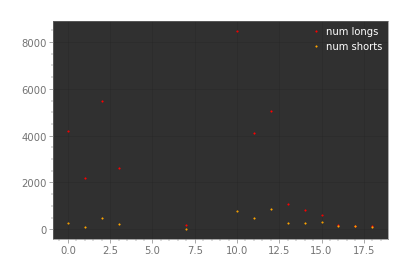

In [544]:
import pandas as pd
num_longs_and_shorts = {
    f"agent_{agent_id}_num_longs": ["sum"]
    for agent_id in range(len(simulator.agents))
}
num_longs_and_shorts.update({
    f"agent_{agent_id}_num_shorts": ["sum"]
    for agent_id in range(len(simulator.agents))
})
trades_agg = trades.groupby("day").agg(num_longs_and_shorts)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()
longs = trades_agg.filter(regex="num_longs").sum(axis=1)
shorts = trades_agg.filter(regex="num_shorts").sum(axis=1)

fix, axes, _ = output_utils.get_gridspec_subplots(nrows=1, ncols=1)
ax = axes[0]
spot_size = 2
ax.scatter(trades_agg["day"][:-1], longs[:-1], label="num longs", c="red", s=spot_size)
ax.scatter(trades_agg["day"][:-1], shorts[:-1], label="num shorts", c="orange", s=spot_size)
ax.legend()
ax.set_xlabel("day")
ax.set_ylabel("number of positions")
text_handle = ax.set_title("Open positions")



<AxesSubplot:>

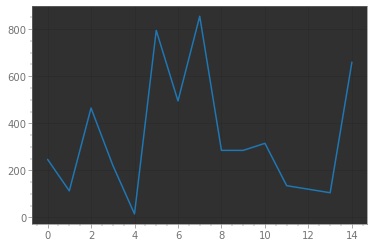

In [547]:
shorts.plot()

<AxesSubplot:>

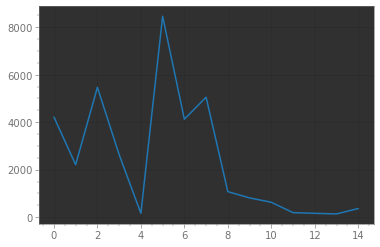

In [548]:
longs.plot()

In [549]:
trades['bond_reserves']

0      1.551102e+07
1      1.526090e+07
2      1.501079e+07
3      1.476069e+07
4      1.451058e+07
           ...     
442    2.858985e+07
443    2.853396e+07
444    2.853396e+07
445    2.853396e+07
446    3.725290e-09
Name: bond_reserves, Length: 447, dtype: float64

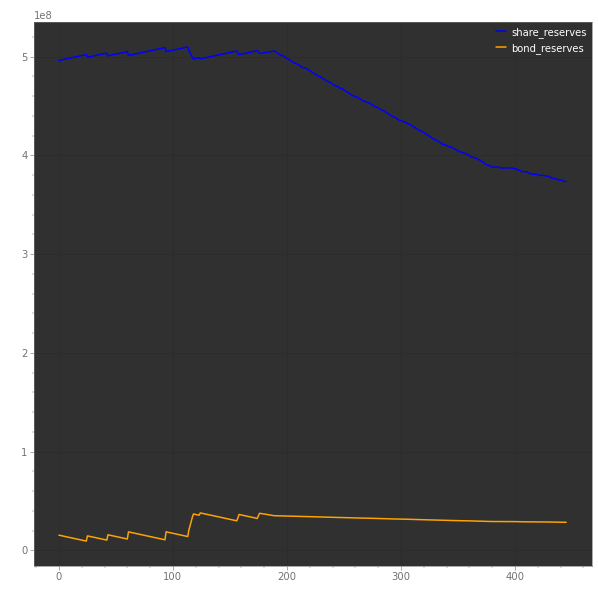

In [550]:
fig, axes, _ = output_utils.get_gridspec_subplots(nrows=1, ncols=1)
ax = trades.iloc[:-1].plot(x="trade_number", y="share_reserves", ax=axes[0], c="blue")
ax = trades.iloc[:-1].plot(x="trade_number", y="bond_reserves", ax=axes[0], c="orange")
ax.set_xlabel("trade number")
ax.set_ylabel("reserve amount")
ax.set_title("Market reserves")
fig.set_size_inches(fig_size)

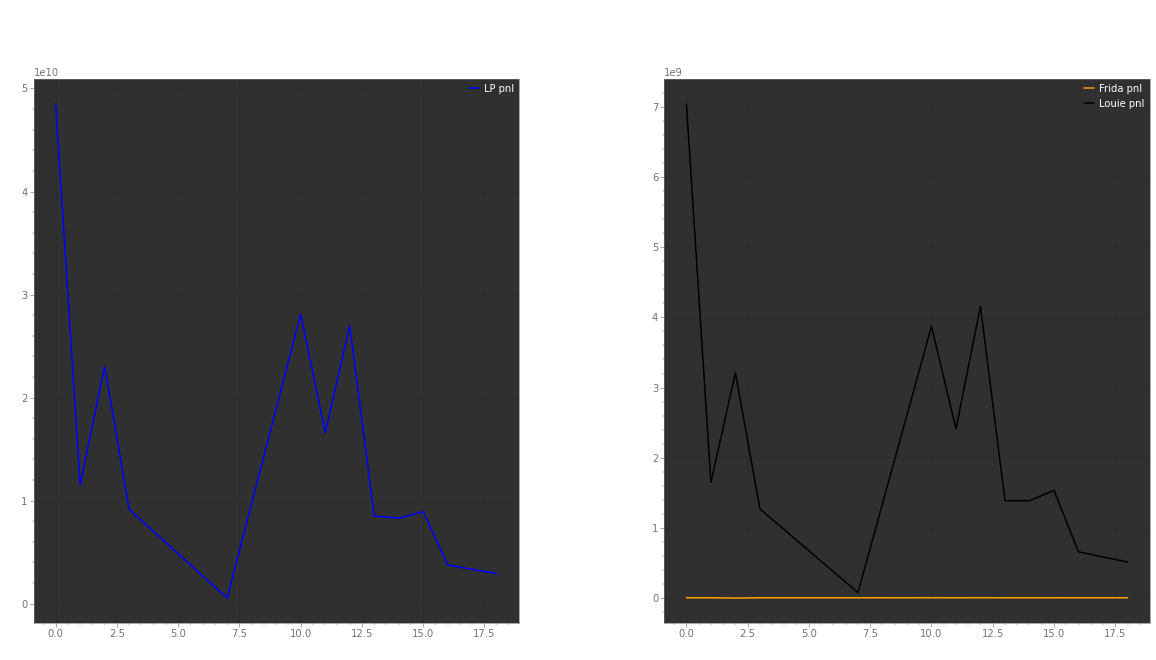

In [555]:
lp_trades = trades.groupby("day").agg(
    {
        f"agent_{0}_pnl": ["sum"]
    }
)
lp_trades.columns = ["_".join(col).strip() for col in lp_trades.columns.values]
lp_trades = lp_trades.reset_index()

fridas = [agent_id for agent_id in range(len(simulator.agents)) if simulator.agents[agent_id].__class__.__name__ == "FixedFrida"]
frida_trades = trades.groupby("day").agg(
    {
        f"agent_{agent_id}_pnl": ["sum"]
        for agent_id in fridas
    }
)
frida_trades.columns = ["_".join(col).strip() for col in frida_trades.columns.values]
frida_trades = frida_trades.reset_index()

louies = [agent_id for agent_id in range(len(simulator.agents)) if simulator.agents[agent_id].__class__.__name__ == "LongLouie"]
louies_trades = trades.groupby("day").agg(
    {
        f"agent_{agent_id}_pnl": ["sum"]
        for agent_id in louies
    }
)
louies_trades.columns = ["_".join(col).strip() for col in louies_trades.columns.values]
louies_trades = louies_trades.reset_index()

fig, axes, _ = output_utils.get_gridspec_subplots(nrows=1, ncols=2, wspace=0.3)

ax = axes[0]
ax.plot(trades_agg["day"][:-1], lp_trades.sum(axis=1)[:-1], label="LP pnl", c="blue")
ax.set_ylabel("base")

ax = axes[1]
ax.plot(trades_agg["day"][:-1], frida_trades.sum(axis=1)[:-1], label="Frida pnl", c="orange")
ax.plot(trades_agg["day"][:-1], louies_trades.sum(axis=1)[:-1], label="Louie pnl", c="black")

for ax in axes:
    ax.set_xlabel("day")
    ax.legend()
text_handle = fig.suptitle("Agent profitability")
fig.set_size_inches((fig_size[0]*2, fig_size[1]))

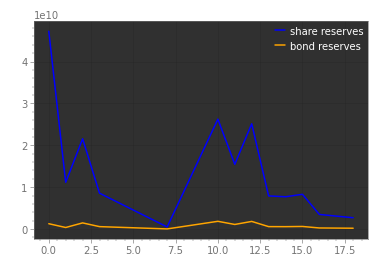

In [556]:
trades_agg = trades.groupby("day").agg(
    {
        "share_reserves": ["sum"],
        "bond_reserves": ["sum"]
    }
)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()

fix, axes, _ = output_utils.get_gridspec_subplots(nrows=1, ncols=1)
ax = trades_agg.iloc[:-1].plot(x="day", y="share_reserves_sum", ax=axes[0], label="share reserves", c="blue")
ax = trades_agg.iloc[:-1].plot(x="day", y="bond_reserves_sum", ax=axes[0], label="bond reserves", c="orange")
ax.set_xlabel("day")
ax.set_ylabel("number of tokenx")
text_handle = ax.set_title("Reserve levels")
fig.set_size_inches(fig_size)

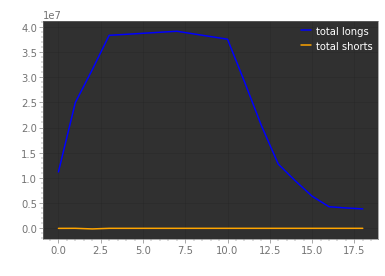

In [557]:
total_longs_and_shorts = { 
    f"agent_{agent_id}_total_longs": ["mean"] # total_longs is an aggregate value recomputed each trade
    for agent_id in range(len(simulator.agents))
}
total_longs_and_shorts.update({
    f"agent_{agent_id}_total_shorts": ["mean"] # total_shorts is an aggregate value recomputed each trade
    for agent_id in range(len(simulator.agents))
})
trades_agg = trades.groupby("day").agg(total_longs_and_shorts)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()
longs = trades_agg.filter(regex="total_longs").sum(axis=1)
shorts = trades_agg.filter(regex="total_shorts").sum(axis=1)

fix, axes, _ = output_utils.get_gridspec_subplots(nrows=1, ncols=1)
ax = axes[0]
ax.plot(trades_agg["day"][:-1], longs[:-1], label="total longs", c="blue")
ax.plot(trades_agg["day"][:-1], shorts[:-1], label="total shorts", c="orange")
ax.legend()
ax.set_xlabel("day")
ax.set_ylabel("base")
text_handle = ax.set_title("Value of open positions")
fig.set_size_inches(fig_size)

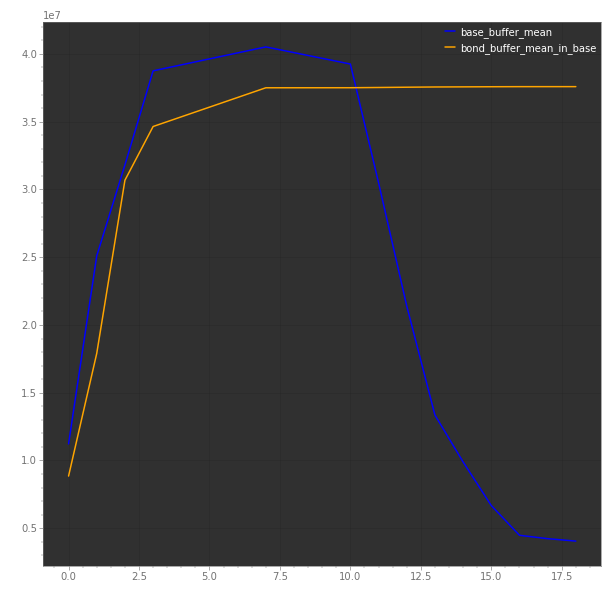

In [558]:
trades_agg = trades.groupby("day").agg(
    {
        "base_buffer": ["mean"],
        "bond_buffer": ["mean"],
        "spot_price": ["mean"],
    }
)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()
trades_agg["bond_buffer_mean_in_base"] = trades_agg["bond_buffer_mean"] / trades_agg["spot_price_mean"]

fig, axes, _ = output_utils.get_gridspec_subplots()
ax = trades_agg.iloc[:-1].plot(x="day", y="base_buffer_mean", ax=axes[0], c="blue")
ax = trades_agg.iloc[:-1].plot(x="day", y="bond_buffer_mean_in_base", ax=axes[0], c="orange")
text_handle = ax.set_title("amount locked")
ax.set_xlabel("day")
ax.set_ylabel("buffer quantities (in base units)")
fig.set_size_inches(fig_size)

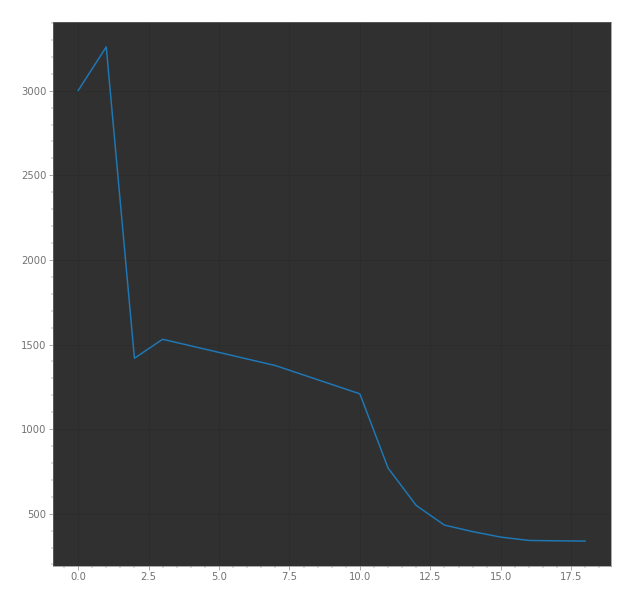

In [559]:
trades_agg = trades.groupby("day").agg(
    {
        "spot_price": ["mean"]
    }
)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()
trades_agg["leverage"] = 1 / (1 - trades_agg["spot_price_mean"])

fig, axes, _ = output_utils.get_gridspec_subplots()
ax = axes[0]
ax.plot(trades_agg["day"][:-1], trades_agg["leverage"][:-1])
text_handle = ax.set_title("Short leverage")
ax.set_xlabel("day")
ax.set_ylabel("1/(1-p)")
fig.set_size_inches(fig_size)